In [1]:
import FinMind
import pandas as pd 
import numpy as np
import talib
import math
import matplotlib.pyplot as plt
import matplotlib

from FinMind.data import DataLoader
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Problem 1

## A

In [2]:
api = DataLoader()
df = api.taiwan_stock_daily(
    stock_id='TAIEX',
    start_date='2012-12-01',
    end_date='2021-12-02'
)
df.drop(columns=['stock_id', 'Trading_money', 'spread', 'Trading_turnover'],inplace=True)
df.rename(columns={'Trading_Volume':'volume', 'max':'high', 'min':'low'},inplace=True)
df

,date,volume,open,high,low,close
0,2012-12-03,3696524900,7582.65,7628.29,7562.19,7599.91
1,2012-12-04,3947860691,7572.11,7600.98,7536.66,7600.98
2,2012-12-05,4858910844,7575.63,7650.12,7567.46,7649.05
3,2012-12-06,4399887242,7660.97,7673.62,7616.79,7623.26
4,2012-12-07,3888752378,7640.25,7672.92,7631.63,7642.26
...,...,...,...,...,...,...
2202,2021-11-26,8639089532,17641.79,17641.79,17330.44,17369.39
2203,2021-11-29,7721871866,17320.01,17415.63,17167.24,17328.09
2204,2021-11-30,9057571836,17369.79,17535.23,17369.79,17427.76
2205,2021-12-01,7020888193,17428.61,17626.21,17374.59,17585.99


In [3]:
df.to_csv('output/problem1A.csv')

## B

In [4]:
close_array = np.array(df['close'])

In [5]:
label = []
for i in range(0, len(close_array)):
    length = len(close_array[i:])
    if length > 21:
        length = 21
    if length == 21:
        for j in range(0, length):
            upper_bound = close_array[i] * 1.04
            lower_bound = close_array[i] * 0.98
            if close_array[i+j] >= upper_bound:
                label.append(1)
                break
            elif close_array[i+j] <= lower_bound:
                label.append(2)
                break
        if len(label) != i+1:
            label.append(0)
    else:
        for j in range(0, length):
            upper_bound = close_array[i] * 1.04
            lower_bound = close_array[i] * 0.98
            if close_array[i+j] >= upper_bound:
                label.append(1)
                break
            elif close_array[i+j] <= lower_bound:
                label.append(2)
                break
        if len(label) != i+1:
            label.append(np.nan)

In [6]:
df['label'] = label
df

,date,volume,open,high,low,close,label
0,2012-12-03,3696524900,7582.65,7628.29,7562.19,7599.91,0.0
1,2012-12-04,3947860691,7572.11,7600.98,7536.66,7600.98,0.0
2,2012-12-05,4858910844,7575.63,7650.12,7567.46,7649.05,0.0
3,2012-12-06,4399887242,7660.97,7673.62,7616.79,7623.26,0.0
4,2012-12-07,3888752378,7640.25,7672.92,7631.63,7642.26,0.0
...,...,...,...,...,...,...,...
2202,2021-11-26,8639089532,17641.79,17641.79,17330.44,17369.39,NaN
2203,2021-11-29,7721871866,17320.01,17415.63,17167.24,17328.09,NaN
2204,2021-11-30,9057571836,17369.79,17535.23,17369.79,17427.76,NaN
2205,2021-12-01,7020888193,17428.61,17626.21,17374.59,17585.99,NaN


In [7]:
df.to_csv('output/problem1B.csv')

## C

In [8]:
df['MA-5'] = (df['close'] - talib.MA(df.close, timeperiod=5, matype=0)) / talib.MA(df.close, timeperiod=5, matype=0)
df['MA-10'] = (df['close'] - talib.MA(df.close, timeperiod=10, matype=0)) / talib.MA(df.close, timeperiod=10, matype=0)
df['MA-20'] = (df['close'] - talib.MA(df.close, timeperiod=20, matype=0)) / talib.MA(df.close, timeperiod=20, matype=0)
df['MA-60'] = (df['close'] - talib.MA(df.close, timeperiod=60, matype=0)) / talib.MA(df.close, timeperiod=60, matype=0)
df['RSI-14'] = talib.RSI(df.close, timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df.close)
df.dropna(inplace=True)

In [9]:
df.to_csv('output/problem1C.csv', index=False)

# Problem 2

## A

In [10]:
df = pd.read_csv('output/problem1C.csv')

In [11]:
train = df[:int(df.shape[0] * 0.7)]
test = df[int(df.shape[0] * 0.7):]

In [12]:
train
test

,date,volume,open,high,low,close,label,MA-5,MA-10,MA-20,MA-60,RSI-14,MACD,MACD_signal,MACD_hist
0,2013-03-06,3923678149,7958.11,7982.39,7936.86,7950.30,0.0,0.003497,0.002135,0.004302,0.024105,56.429268,43.544898,51.947231,-8.402333
1,2013-03-07,3629314119,7950.90,7984.29,7942.37,7960.51,2.0,0.003202,0.003384,0.004586,0.024626,57.172977,43.431253,50.244035,-6.812782
2,2013-03-08,4161212736,7981.00,8029.14,7981.00,8015.14,2.0,0.008803,0.009412,0.010319,0.030742,61.008046,47.205221,49.636272,-2.431051
3,2013-03-11,4284798782,8021.88,8089.21,8001.85,8038.72,2.0,0.007425,0.011721,0.012088,0.032912,62.566221,51.505108,50.010039,1.495069
4,2013-03-12,4200531442,8039.00,8063.23,7986.59,7994.71,2.0,0.000355,0.005587,0.005668,0.026441,57.914429,50.776243,50.163280,0.612963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,2019-03-27,4025702296,10542.68,10556.75,10515.86,10542.70,1.0,-0.002205,0.002210,0.011252,0.049845,62.857814,119.372083,121.920772,-2.548689
1489,2019-03-28,3801407450,10529.02,10536.26,10499.29,10536.26,1.0,-0.001429,-0.000185,0.009933,0.047706,62.276780,114.009544,120.338526,-6.328982
1490,2019-03-29,4735272511,10551.99,10641.04,10525.27,10641.04,0.0,0.008463,0.007828,0.018747,0.056436,67.534963,116.867389,119.644299,-2.776909
1491,2019-04-01,5543097993,10714.68,10735.07,10627.01,10642.63,0.0,0.005505,0.006740,0.017474,0.054855,67.608746,117.901457,119.295730,-1.394273


,date,volume,open,high,low,close,label,MA-5,MA-10,MA-20,MA-60,RSI-14,MACD,MACD_signal,MACD_hist
1493,2019-04-03,4099474088,10725.17,10741.56,10690.23,10704.38,0.0,0.005775,0.009422,0.019807,0.057085,70.465349,123.474495,120.431487,3.043008
1494,2019-04-08,5397269130,10759.96,10807.05,10759.96,10800.57,0.0,0.009797,0.016662,0.026581,0.064269,74.463781,131.545581,122.654306,8.891275
1495,2019-04-09,5083146536,10805.39,10851.60,10793.77,10851.60,0.0,0.010589,0.019426,0.028450,0.067177,76.297106,140.440755,126.211596,14.229159
1496,2019-04-10,4653211646,10839.93,10875.65,10815.61,10868.14,0.0,0.007896,0.017265,0.027011,0.066809,76.876575,147.128875,130.395052,16.733823
1497,2019-04-11,5053919906,10869.24,10887.12,10797.76,10808.77,0.0,0.000192,0.009350,0.019159,0.058808,70.238811,145.956104,133.507262,12.448842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,2021-11-16,8855573631,17639.96,17708.10,17629.80,17693.13,2.0,0.006917,0.015024,0.028237,0.036045,70.202960,189.168001,129.477847,59.690154
2129,2021-11-17,9046216805,17705.29,17764.04,17669.58,17764.04,2.0,0.008607,0.015353,0.029736,0.038755,71.865814,203.814901,144.345258,59.469643
2130,2021-11-18,9921581700,17767.06,17841.37,17748.21,17841.37,2.0,0.008544,0.015348,0.031374,0.042160,73.596310,219.136490,159.303504,59.832986
2131,2021-11-19,9158530889,17864.19,17986.18,17786.05,17818.31,2.0,0.003834,0.011035,0.027280,0.039801,72.170724,226.803758,172.803555,54.000203


## B

In [13]:
param_dict = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

## C

label
0.0    592
1.0    271
2.0    630
Name: volume, dtype: int64

<AxesSubplot:xlabel='label'>

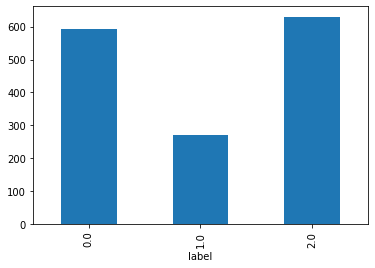

In [14]:
train.groupby('label').count()['volume']
train.groupby('label').count()['volume'].plot(kind='bar')

label
0.0    129
1.0    253
2.0    258
Name: volume, dtype: int64

<AxesSubplot:xlabel='label'>

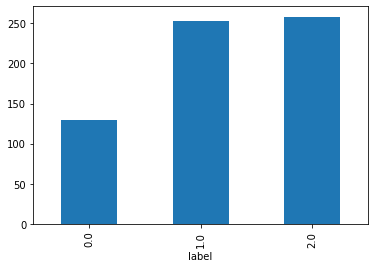

In [15]:
test.groupby('label').count()['volume']
test.groupby('label').count()['volume'].plot(kind='bar')

## D

In [16]:
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

C:\Users\CGVMISLAB\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']

In [18]:
model = GridSearchCV(RandomForestClassifier(), param_grid=param_dict, cv=3, return_train_score=True, n_jobs=4, verbose=3)
model.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             return_train_score=True, verbose=3)

## E

In [19]:
model.cv_results_['mean_train_score'].max()

0.9678509683625625

In [20]:
model.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 200}

In [21]:
best_test_score = model.best_estimator_.score(X_test, y_test)
best_test_score

0.4546875

## F

In [22]:
y_score = model.predict_proba(X_test)
y_test = label_binarize(y_test, classes=[0, 1, 2])

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

(-0.05, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic for multi-class data')

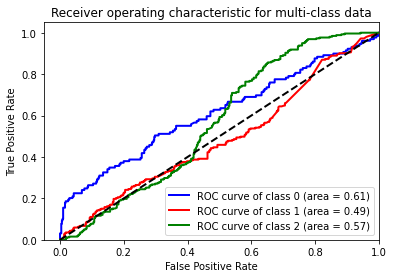

In [24]:
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()